# Cvičení 05a— MLP v PyTorch (Replikace 'NN from Scratch')

O co tady jde:
- Cílem tohoto cvičení je replikovat funkcionalitu MLP pro klasifikaci na datasetu Two Moons, kterou jsme implementovali "od nuly", ale tentokrát s využitím knihovny PyTorch.

## 1) Knihovny a příprava dat

Nastavíme potřebné knihovny a připravíme data Two Moons pro PyTorch (konverze na Tenzory).

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Nastavení seed pro reprodukovatelnost
torch.manual_seed(42)
np.random.seed(42)

In [10]:
# 1. Generování dat Two Moons
X_np, y_np = make_moons(n_samples=1000, noise=0.15, random_state=42)

# 2. Rozdělení na trénovací a testovací sady
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42
)

# 3. Konverze na PyTorch Tenzory
# X data musí být float
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)

# y labely musí být long (indexy tříd pro CrossEntropyLoss)
y_train = torch.tensor(y_train_np, dtype=torch.long)
y_test = torch.tensor(y_test_np, dtype=torch.long)

print(f"Trénovací data (X, y): {X_train.shape}, {y_train.shape}")
print(f"Testovací data (X, y): {X_test.shape}, {y_test.shape}")

Trénovací data (X, y): torch.Size([800, 2]), torch.Size([800])
Testovací data (X, y): torch.Size([200, 2]), torch.Size([200])


## 2) Definice MLP modelu

Definujeme třídu modelu, která dědí z `nn.Module`.

`nn.Linear(in, out)`: Implementuje lineární vrstvu ($z=xW+b$).

`nn.ReLU()`: Implementuje aktivační funkci.

In [12]:
class TwoMoonsMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoMoonsMLP, self).__init__()
        
        # 1. Lineární vrstva: Vstup (2) -> Skrytá (16)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Aktivace
        self.relu = nn.ReLU()
        
        # 2. Lineární vrstva: Skrytá (16) -> Výstup (2 logity)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Dopředný průchod
        x = self.fc1(x) 
        x = self.relu(x)
        x = self.fc2(x) # Finální logity 'z'
        return x

# Inicializace modelu
INPUT_DIM = X_train.shape[1]
OUTPUT_DIM = len(np.unique(y_np))
HIDDEN_DIM = 16

model = TwoMoonsMLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
print(model)

TwoMoonsMLP(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)


## 3) Nastavení trénování (Loss & Optimizer)

Použijeme vestavěný **CrossEntropyLoss** a **Adam** optimalizátor.

In [14]:
# Loss funkce: nn.CrossEntropyLoss (ekvivalent naší SoftmaxCE)
criterion = nn.CrossEntropyLoss()

# Optimalizátor: Použijeme Adam
optimizer = optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 300
BATCH_SIZE = 32

## 4) Trénovací smyčka

Základní trénovací smyčka s manuálním voláním `zero_grad()`, `backward()` a `optimizer.step()`.

In [16]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    # --- Trénovací fáze (model.train()) ---
    model.train() 
    
    optimizer.zero_grad() # 1. Vynulování gradientů
    
    outputs = model(X_train) # 2. Dopředný průchod (outputs jsou logity)
    loss = criterion(outputs, y_train) # 3. Výpočet ztráty
    
    loss.backward() # 4. Zpětný průchod (Backpropagation)
    optimizer.step() # 5. Aktualizace vah
    
    train_losses.append(loss.item())
    
    # --- Testovací fáze (model.eval()) ---
    model.eval() 
    with torch.no_grad(): # Vypnutí počítání gradientů
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
        
    if (epoch + 1) % 50 == 0:
        # Přesnost: Z logitů najdeme maximální (predicted) třídu
        _, predicted = torch.max(test_outputs.data, 1)
        test_acc = accuracy_score(y_test_np, predicted.numpy())
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Test Acc: {test_acc:.4f}')

Epoch [50/300], Train Loss: 0.2521, Test Acc: 0.9000
Epoch [100/300], Train Loss: 0.1904, Test Acc: 0.9200
Epoch [150/300], Train Loss: 0.1231, Test Acc: 0.9650
Epoch [200/300], Train Loss: 0.0820, Test Acc: 0.9850
Epoch [250/300], Train Loss: 0.0583, Test Acc: 0.9850
Epoch [300/300], Train Loss: 0.0467, Test Acc: 0.9950


## 5) Vizualizace výsledků

Vykreslení ztráty a rozhodovací hranice.

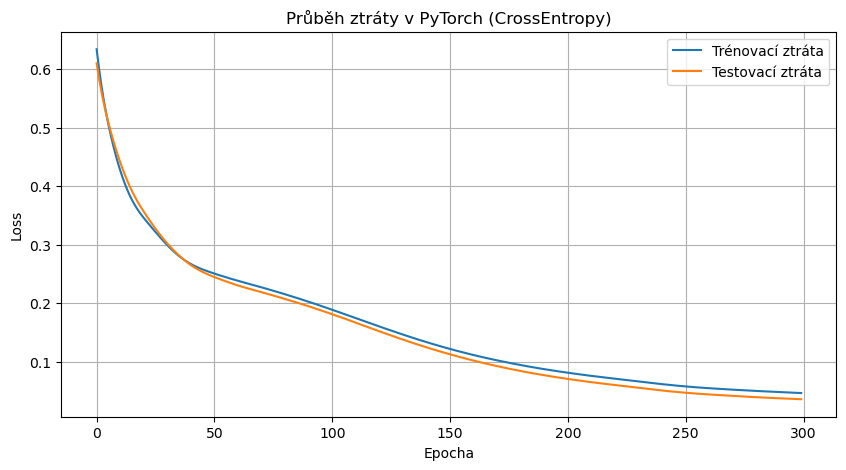

In [18]:
# Vykreslení trénovací a testovací ztráty
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Trénovací ztráta')
plt.plot(test_losses, label='Testovací ztráta')
plt.title('Průběh ztráty v PyTorch (CrossEntropy)')
plt.xlabel('Epocha')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

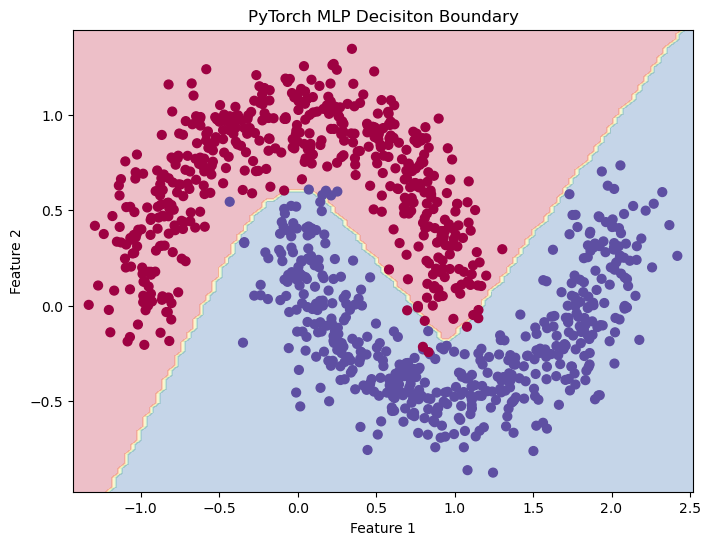

In [19]:
def plot_decision_boundary_pytorch(model, X_np, y_np):
    """Vykreslí rozhodovací hranici pro 2D PyTorch model."""
    x_min, x_max = X_np[:, 0].min() - 0.1, X_np[:, 0].max() + 0.1
    y_min, y_max = X_np[:, 1].min() - 0.1, X_np[:, 1].max() + 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        # Získání logitů a určení třídy (argmax)
        Z = model(grid_tensor)
        _, Z = torch.max(Z.data, 1)
    
    Z = Z.numpy().reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Spectral)
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, s=40, cmap=plt.cm.Spectral)
    plt.title('PyTorch MLP Decisiton Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    
plot_decision_boundary_pytorch(model, X_np, y_np)

# Cvičení 05b — Generování textu pomocí Char-RNN

Tato úloha zavede rekurentní neuronové sítě (RNN), které jsou klíčové pro zpracování sekvencí a ukáže, jak se model učí předpovídat následující znak v textu (Language Modeling).

## 0. Nastavení zařízení

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používám zařízení: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")


Používám zařízení: cuda
GPU Name: NVIDIA GeForce RTX 4090


## 1. Příprava dat pro Char-RNN

Nejprve potřebujeme textový korpus -- text **Romeo a Julie**.

In [78]:
import requests
import torch.nn.functional as F # Pro one_hot a Softmax

try:
    # URL pro stažení Romea a Julie
    url = "https://www.gutenberg.org/cache/epub/1513/pg1513.txt"
    response = requests.get(url)
    
    # Oříznutí hlaviček/patiček Project Gutenberg
    text = response.text
    start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***"
    end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***"
    
    start_index = text.find(start_marker) + len(start_marker)
    end_index = text.find(end_marker)
    corpus = text[start_index:end_index].strip()
    print("Úspěšně načten text 'Romeo a Julie'.")

except requests.exceptions.RequestException:
    print("Chyba při stahování textu. Používám zástupný text.")
    corpus = "This is a placeholder corpus for recurrent neural network training."
    
# Standardizace korpusu
corpus = corpus.replace('\n', ' ').replace('\r', ' ').replace('--', ' ')
corpus = ' '.join(corpus.split()) 

# Vytvoření mapování
char_to_ix = {ch: i for i, ch in enumerate(sorted(list(set(corpus))))}
ix_to_char = {i: ch for ch, i in char_to_ix.items()}
VOCAB_SIZE = len(char_to_ix)

# Konverze korpusu na tenzor indexů
data = torch.tensor([char_to_ix[ch] for ch in corpus], dtype=torch.long)

print(f"Velikost slovníku (VOCAB_SIZE): {VOCAB_SIZE}")
print(f"Délka korpusu (znaků): {len(corpus)}")


Úspěšně načten text 'Romeo a Julie'.
Velikost slovníku (VOCAB_SIZE): 69
Délka korpusu (znaků): 141104


## 2. Definice Char-RNN modelu

Definujeme model s věma vrstvami `nn.RNN` a **one-hot encodingem** na vstupu.

In [81]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.one_hot_size = vocab_size
        
        # Rekurentní vrstva: nn.RNN
        self.rnn = nn.RNN(input_size=vocab_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers,
                          batch_first=True)
        
        # Lineární vrstva: Skrytý stav -> Logity pro VOCAB_SIZE
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_seq, hidden):
        # Převod vstupních indexů na One-Hot (Batch, Sequence Length, Vocab Size)
        input_one_hot = F.one_hot(input_seq, num_classes=self.one_hot_size).float()
        
        # RNN průchod
        out, hidden = self.rnn(input_one_hot, hidden)
        
        # Reshape pro aplikaci lineární vrstvy na všechny časové kroky
        out = self.fc(out.reshape(-1, self.hidden_size))
        
        return out, hidden

    def init_hidden(self, batch_size):
        # Inicializace nultého skrytého stavu (h0)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

Pomocná funkce pro efektivní sekvenční batching

In [84]:
def get_batch(data, seq_len, batch_size):
    """Generuje náhodné, ale souvislé batche pro trénink."""
    
    n_batches = data.size(0) // (batch_size * seq_len)
    data = data[:n_batches * batch_size * seq_len]
    data = data.reshape(batch_size, -1)
    
    start_index = torch.randint(0, data.size(1) - seq_len, (1,)).item()
    
    x = data[:, start_index : start_index + seq_len].contiguous()
    y = data[:, start_index + 1 : start_index + seq_len + 1].contiguous()
    
    # Přesun na GPU/device
    return x.to(device), y.to(device)

Pomocná funkce pro kreativní generování

In [87]:
def generate_text_creative(model, start_char, length, temperature=0.8):
    model.eval()
    
    # Získání zařízení, na kterém model aktuálně běží
    current_device = next(model.parameters()).device 
    
    try:
        input_char_idx = char_to_ix[start_char]
    except KeyError:
        print(f"Chyba: Počáteční znak '{start_char}' není ve slovníku. Používám mezeru.")
        start_char = ' '
        input_char_idx = char_to_ix[start_char]
        
    generated_text = start_char
    
    # Přesun input_seq a hidden na správné zařízení
    input_seq = torch.tensor([[input_char_idx]], dtype=torch.long).to(current_device)
    hidden = model.init_hidden(batch_size=1).to(current_device)

    for _ in range(length):
        output, hidden = model(input_seq, hidden)
        
        output_logits = output[-1] / temperature
        probabilities = torch.nn.functional.softmax(output_logits, dim=0)
        
        next_char_idx = torch.multinomial(probabilities, num_samples=1).item()
        next_char = ix_to_char[next_char_idx]
        
        generated_text += next_char
        
        # Zajištění, že další input je na správném zařízení
        input_seq = torch.tensor([[next_char_idx]], dtype=torch.long).to(current_device)
        
    return generated_text

## 3. Trénink Char-RNN

In [90]:
# Hyperparametry (nastaveno pro efektivní trénink na GPU/CPU)
HIDDEN_SIZE = 256
NUM_LAYERS = 2 
LR = 0.001
EPOCHS_RNN = 2000
BATCH_SIZE = 64
SEQ_LEN = 100
GENERATION_LENGTH = 300 
GENERATION_START = 'A'

rnn_model = CharRNN(VOCAB_SIZE, HIDDEN_SIZE, NUM_LAYERS).to(device)
rnn_criterion = nn.CrossEntropyLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=LR)

print(f"Trénovací parametry: Batch Size {BATCH_SIZE}, Seq Len {SEQ_LEN}, Epochs {EPOCHS_RNN}")
print("Spouštím trénink s efektivním batchingem...")

for epoch in range(1, EPOCHS_RNN + 1):
    rnn_model.train()
    
    # 1. Získání dat (input_batch i target_batch jsou již na device)
    input_batch, target_batch = get_batch(data, SEQ_LEN, BATCH_SIZE)
    
    rnn_optimizer.zero_grad()
    
    # 2. Inicializace skrytého stavu na device
    hidden = rnn_model.init_hidden(batch_size=BATCH_SIZE).to(device)
    
    outputs, hidden = rnn_model(input_batch, hidden)
    
    # Ztráta: target musí být 1D (Batch*Seq_len) pro CrossEntropyLoss
    loss = rnn_criterion(outputs, target_batch.reshape(-1))
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), 1.0) 
    rnn_optimizer.step()
    
    
    # --- VÝPISY A GENERACE ---
    if epoch % 500 == 0 or epoch == 1: 
        print(f'Epoch [{epoch}/{EPOCHS_RNN}], Loss: {loss.item():.4f}')
        
        if epoch % 500 == 0:
            # Přesun modelu na CPU pro generování (pro numpy kompatibilitu)
            generated_text = generate_text_creative(
                model=rnn_model.cpu(), 
                start_char=GENERATION_START, 
                length=GENERATION_LENGTH, 
                temperature=0.8
            )
            rnn_model.to(device) # Vracíme model zpět na GPU
            
            print(f'   -> Ukázka po {epoch} epochách: {generated_text}')


Trénovací parametry: Batch Size 64, Seq Len 100, Epochs 2000
Spouštím trénink s efektivním batchingem...
Epoch [1/2000], Loss: 4.2329
Epoch [500/2000], Loss: 1.7388
   -> Ukázka po 500 epochách: Agh thee cove is a beivint Thou wive your forer. The fulle bie. Her then of the canuthal such and now spives manter Copsind in pon were this ar with you souse oot, hou haw, hath Romeo det letper a distent in coverver Stars to hour deant a will davey hath hee, And live in the sermeem, Sesping? That ha
Epoch [1000/2000], Loss: 1.4965
   -> Ukázka po 1000 epochách: And yet to thy with his gone Montague, And she fisters in have that blendst greed lime! SAMLSTII. I’ll exy a masty, To Juliet! MERCUTIO. No man, thou all thy life me the still strance as the tears is quince coull thee remone a trunk’s mind! Friend Be gone, for thy bless lieg dodes not your house have
Epoch [1500/2000], Loss: 1.1671
   -> Ukázka po 1500 epochách: AMPSON. Not wost make the deriagy? FRIAR LAWRENCE. The tell me love can hea

## 4) Generování textu

In [107]:
final_generated = generate_text_creative(
    model=rnn_model.cpu(),
    start_char='M', 
    length=500, 
    temperature=0.7
)

print(f"Generováno z 'M' (T=0.7):\n'{final_generated}'")

Generováno z 'M' (T=0.7):
'MERCUTIO. But you love the wenthine’s the contrain’d from his faster faretest. Sweet my maskes to the many dies quarrel with his lady manile benose in their sick she would slay a haddle by the poace, man to hearth doth go. SAMPSON. God so mair a hard, And like me to thee an honour he nor himself to the hants. O God’s men fill; Tybalt, from the night before the now. But o’er the clouds, And the worf the that fair in this place of any for Romeo and Paris and having soun to enemy. JULIET. Am your be'
